In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.callbacks import History
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,AveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization
from keras.models import Sequential,Model

In [2]:
data_path="dataset"
categories=os.listdir(data_path)
print(categories)
num_classes=2

['without_mask', 'with_mask']


In [3]:
img_size=124
data=[]
labels=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            labels.append(category)

        except Exception as e:
            print('Exception:',e)

In [4]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
labels=np.array(labels)

In [5]:
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)
x_train.shape


(1100, 124, 124, 1)

In [6]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=data.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

In [7]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.25)

Epoch 1/10
26/26 [==============================] - 212s 8s/step - loss: 0.7423 - accuracy: 0.5345 - val_loss: 0.6627 - val_accuracy: 0.6545
Epoch 2/10
26/26 [==============================] - 205s 8s/step - loss: 0.5819 - accuracy: 0.7103 - val_loss: 0.4766 - val_accuracy: 0.8218
Epoch 3/10
26/26 [==============================] - 208s 8s/step - loss: 0.3380 - accuracy: 0.8655 - val_loss: 0.2959 - val_accuracy: 0.8800
Epoch 4/10
26/26 [==============================] - 209s 8s/step - loss: 0.2286 - accuracy: 0.9200 - val_loss: 0.3046 - val_accuracy: 0.8727
Epoch 5/10
26/26 [==============================] - 209s 8s/step - loss: 0.1533 - accuracy: 0.9467 - val_loss: 0.1288 - val_accuracy: 0.9600
Epoch 6/10
26/26 [==============================] - 209s 8s/step - loss: 0.1018 - accuracy: 0.9636 - val_loss: 0.1417 - val_accuracy: 0.9491
Epoch 7/10
26/26 [==============================] - 201s 8s/step - loss: 0.0606 - accuracy: 0.9758 - val_loss: 0.1115 - val_accuracy: 0.9564
Epoch 8/10
26

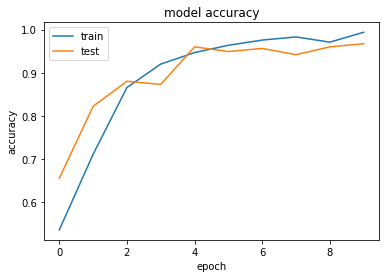

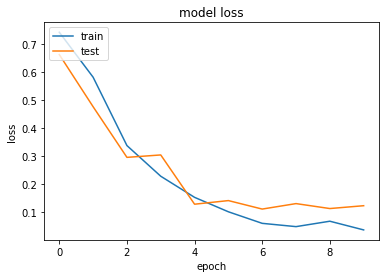

In [9]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(('train', 'test'),loc ='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(('train', 'test'),loc ='upper left')
plt.show()

In [13]:
face_classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap=cv2.VideoCapture(0)

labels_text={0:'MASK',1:'NO MASK'}
color_text={0:(0,255,0),1:(0,0,255)}

while(True):
    ret,img=cap.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_classifier.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(124,124))
        
        
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,124,124,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_text[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_text[label],-1)
        cv2.putText(img, labels_text[label], (x, y),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()